<a href="https://colab.research.google.com/github/ClarenceKaranja/ROBUST-PORTFOLIO-OPTIMIZATION-WITH-RISK-DECAY/blob/main/Markowitz_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install plotly_express
!pip install yfinance

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td
from scipy import optimize
from scipy.stats import shapiro
from scipy.stats import ttest_rel

In [9]:
import yfinance as yf
from datetime import datetime as dt, timedelta as td

end = dt.today()
start = end - td(days=2000)
stocks = 'AMZN TSLA META MSFT NVDA AVGO FICO'.split()

# Fetch historical data
df = yf.download(stocks, start=start, end=end)

# Print the DataFrame
print(df)

[*********************100%%**********************]  7 of 7 completed
             Adj Close                                                   \
                  AMZN        AVGO         FICO        META        MSFT   
Date                                                                      
2018-06-11   84.456001  215.166794   196.589996  191.539993   95.177780   
2018-06-12   84.937500  215.661758   194.020004  192.399994   95.422661   
2018-06-13   85.242996  217.435379   197.470001  192.410004   94.989388   
2018-06-14   86.193001  221.460983   200.720001  196.809998   95.526276   
2018-06-15   85.798500  222.921219   199.970001  195.850006   94.311195   
...                ...         ...          ...         ...         ...   
2023-11-22  146.710007  972.000000  1065.170044  341.489990  377.850006   
2023-11-24  146.740005  978.869995  1069.540039  338.230011  377.429993   
2023-11-27  147.729996  950.239990  1081.959961  334.700012  378.609985   
2023-11-28  147.029999  946.349

In [10]:
# remove multilevel
df.columns = ['_'.join(col) for col in df.columns]

# Just study adj close
df = df.iloc[:,:7]

In [11]:
df.head()

,Adj Close_AMZN,Adj Close_AVGO,Adj Close_FICO,Adj Close_META,Adj Close_MSFT,Adj Close_NVDA,Adj Close_TSLA
Date,,,,,,,
2018-06-11,84.456001,215.166794,196.589996,191.539993,95.177780,64.554642,22.139999
2018-06-12,84.937500,215.661758,194.020004,192.399994,95.422661,65.040146,22.851334
2018-06-13,85.242996,217.435379,197.470001,192.410004,94.989388,64.995544,22.985332
2018-06-14,86.193001,221.460983,200.720001,196.809998,95.526276,66.112663,23.848000
2018-06-15,85.798500,222.921219,199.970001,195.850006,94.311195,65.703964,23.878000


In [12]:
px.line(df * 100 / df.iloc[0])

In [13]:
# Filter the data frame to include only the data for the year 2018
df_2023 = df[df.index.year == 2023]

# Plot the line chart for the filtered data frame
fig = px.line(df_2023 * 100 / df_2023.iloc[0])
fig.show()

In [14]:
ret_port = df.pct_change()
px.line(ret_port)

In [15]:
# Filter the data frame to include only the data for the year 2018
df_2018 = df[df.index.year == 2018]

# Calculate the percentage change of the filtered data frame
ret_port_2018 = df_2018.pct_change()

# Plot the line chart for the filtered data frame
fig = px.line(ret_port_2018)
fig.show()


# MEAN VARIANCE OPTIMIZATION/ MVO

In [16]:
#Setting Random Seed, When you set a random seed, it ensures that if you run the same code again, you'll get the same random numbers.
np.random.seed(1)

# Generating Random Weights
#This line generates an array of random numbers (weights) for each security. (4, 1) specifies that you want a 4x1 matrix (column vector) of random numbers
weights = np.random.random((7,1))

# Normalizing Weights
# line normalizes the weights so that they sum up to 1. This makes them represent proportions of the total investment.
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# Log Returns Calculation
log_ret = np.log(df / df.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk) Calculation
# This calculates the expected volatility of the portfolio, a measure of risk. It involves the covariance matrix of log returns.
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Sharpe ratio Calculation:
# This calculates the Sharpe ratio, a measure of the risk-adjusted return. It's the ratio of expected return to expected volatility.
sr = exp_ret / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [2.23586532e-01 3.86202295e-01 6.13221088e-05 1.62095742e-01
 7.86832356e-02 4.95073783e-02 9.98634946e-02]

Expected return of the portfolio is : 0.2250777768746251

Volatility of the portfolio: 0.3237060113890338

Sharpe ratio of the portfolio: 0.6953154064356374


Monte Carlo Simulation

In [17]:
# setting up the parameters for the Monte Carlo Simulation:
# number of simulation
n = 100_000

# Initialization of Arrays
# initialize arrays to store the weights, volatility, Sharpe ratio, and return for each simulated portfolio.
port_weights = np.zeros(shape=(n,len(df.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

In [18]:
# Number of Securities (the number of securities in the dataset)
num_securities = len(df.columns)
num_securities

7

In [19]:
# This loop performs the Monte Carlo Simulation:
for i in range(n):
    # Randomly Generate Portfolio Weights
    weights = np.random.random(7)

    # normalizes the weights to ensure that the sum is equal to 1
    weights /= np.sum(weights)

    # stores the generated weights for each security in the port_weights array.
    port_weights[i,:] = weights

    # calculates the expected return for the portfolio based on the randomly generated weights.
    exp_ret = log_ret.mean().dot(weights)*252

    # stores the calculated expected return in the port_return array.
    port_return[i] = exp_ret

    # calculates the expected volatility (risk) for the portfolio based on the randomly generated weights.
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))

    # stores the calculated expected volatility in the port_volatility array.
    port_volatility[i] = exp_vol

    #  calculates the Sharpe ratio for the portfolio based on the randomly generated weights.
    sr = exp_ret / exp_vol

    # stores the calculated Sharpe ratio in the port_sr array.
    port_sr[i] = sr

In [20]:
# identifys the portfolio with the maximum Sharpe Ratio (SR) from the Monte Carlo Simulation results
# Index of Maximum Sharpe Ratio
# finds the maximum Sharpe Ratio from the array port_sr, which stores the Sharpe Ratios for each simulated portfolio.
max_sr = port_sr.max()
print(max_sr)
# Index of Maximum Sharpe Ratio:
# finds the index (or position) of the maximum Sharpe Ratio in the array port_sr. This index will be used to retrieve the corresponding values for return and volatility.
ind = port_sr.argmax()
print(ind)
# Return and Volatility at Maximum Sharpe Ratio
# lines extract the return and volatility of the portfolio that corresponds to the maximum Sharpe Ratio.
max_sr_ret = port_return[ind]
print(max_sr_ret)

max_sr_vol = port_volatility[ind]
print(max_sr_vol)

0.9349564007271678
55695
0.3015340764489308
0.32251137723043655


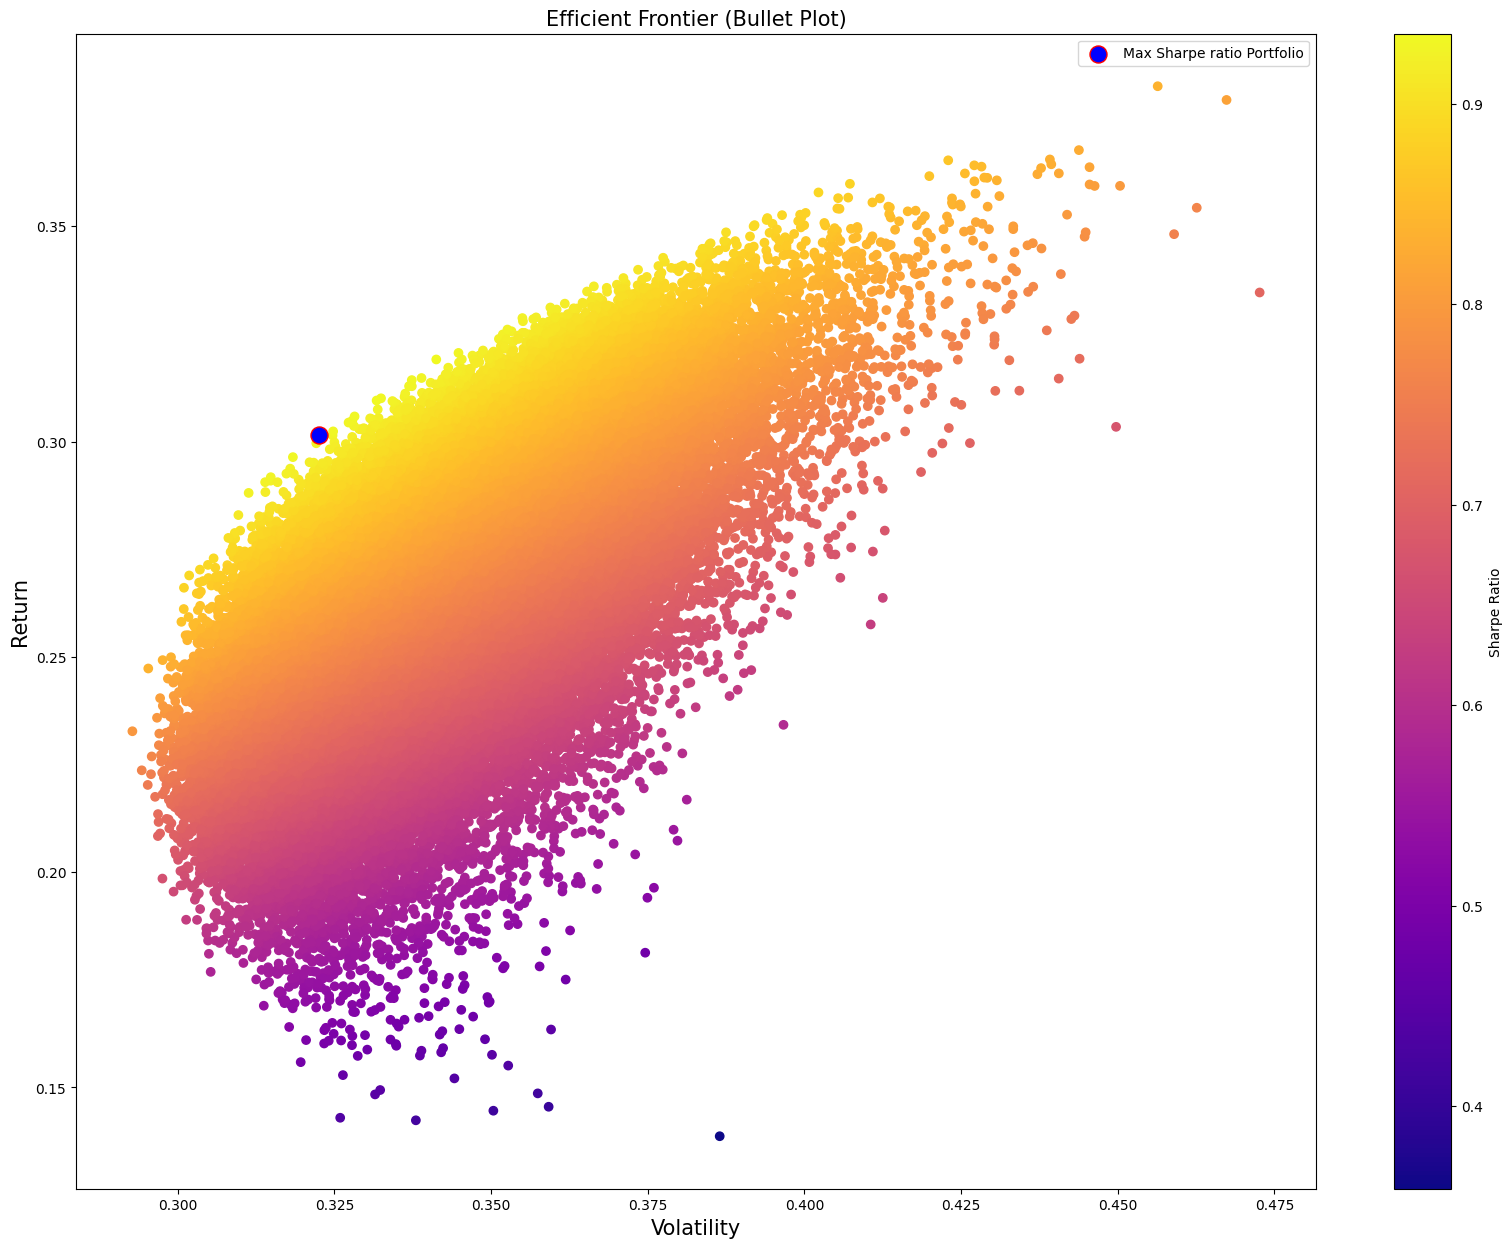

In [21]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();

THE PORTFOLIO YOU SHOULD HAVE IF YOU ARE USING THE MVO

In [22]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

# best portfolio return
print(f'\nMarkowitz(mvo) optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

0.37 % of AMZN should be bought.
17.7 % of TSLA should be bought.
23.13 % of META should be bought.
1.6 % of MSFT should be bought.
36.7 % of NVDA should be bought.
4.14 % of AVGO should be bought.
16.35 % of FICO should be bought.

Markowitz(mvo) optimal portfolio return is : 30.15% with volatility 0.32251137723043655


## MEAN VARIANCE OPTIMIZATION WITH RISK DECAY


In [23]:
# Function to calculate the risk decay based on the provided model
def calculate_risk_decay(initial_risk, decay_rate, time):
    return initial_risk * np.exp(-decay_rate * time)

# Set the decay rate
custom_decay_rate = 0.05

# Modified function to get expected return and volatility considering risk decay
def get_ret_vol_sr_custom(weights, time):
    weights = np.array(weights)
    log_returns = np.log(df / df.shift(1))
    decayed_risk = calculate_risk_decay(log_returns.std(), custom_decay_rate, time)
    ret = log_returns.mean().dot(weights) * 252
    vol = np.sqrt(weights.T.dot(252 * (log_returns.cov() * decayed_risk).dot(weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

In [24]:
# Number of simulations
num_simulations = 100_000

# Initialize arrays to store results
custom_port_weights = np.zeros(shape=(num_simulations, len(df.columns)))
custom_port_volatility = np.zeros(num_simulations)
custom_port_sr = np.zeros(num_simulations)
custom_port_return = np.zeros(num_simulations)

In [25]:
# Number of securities
num_custom_securities = len(df.columns)
print(num_custom_securities)
# Set the initial date and time
custom_start_date = dt.today() - td(days=2000)
print(custom_start_date)

7
2018-06-09 01:15:34.150729


Monte Carlo Simulation

In [26]:
# Monte Carlo Simulation
for i in range(num_simulations):
    # Weight each security
    custom_weights = np.random.random(7)
    custom_weights /= np.sum(custom_weights)
    custom_port_weights[i, :] = custom_weights

    # Calculate the time decay
    custom_time_decay = i / num_simulations  # Adjust as needed based on the desired time decay logic

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    custom_exp_ret = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[0]
    custom_port_return[i] = custom_exp_ret

    # Exp Volatility (Risk)
    custom_exp_vol = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[1]
    custom_port_volatility[i] = custom_exp_vol

    # Sharpe ratio
    custom_sr = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[2]
    custom_port_sr[i] = custom_sr


In [27]:
# Index of max Sharpe Ratio
custom_max_sr = custom_port_sr.max()
custom_ind = custom_port_sr.argmax()

print("Max Sharpie ratio", custom_max_sr)

# Return and Volatility at Max SR
custom_max_sr_ret = custom_port_return[custom_ind]
custom_max_sr_vol = custom_port_volatility[custom_ind]

Max Sharpie ratio 6.04803390057618


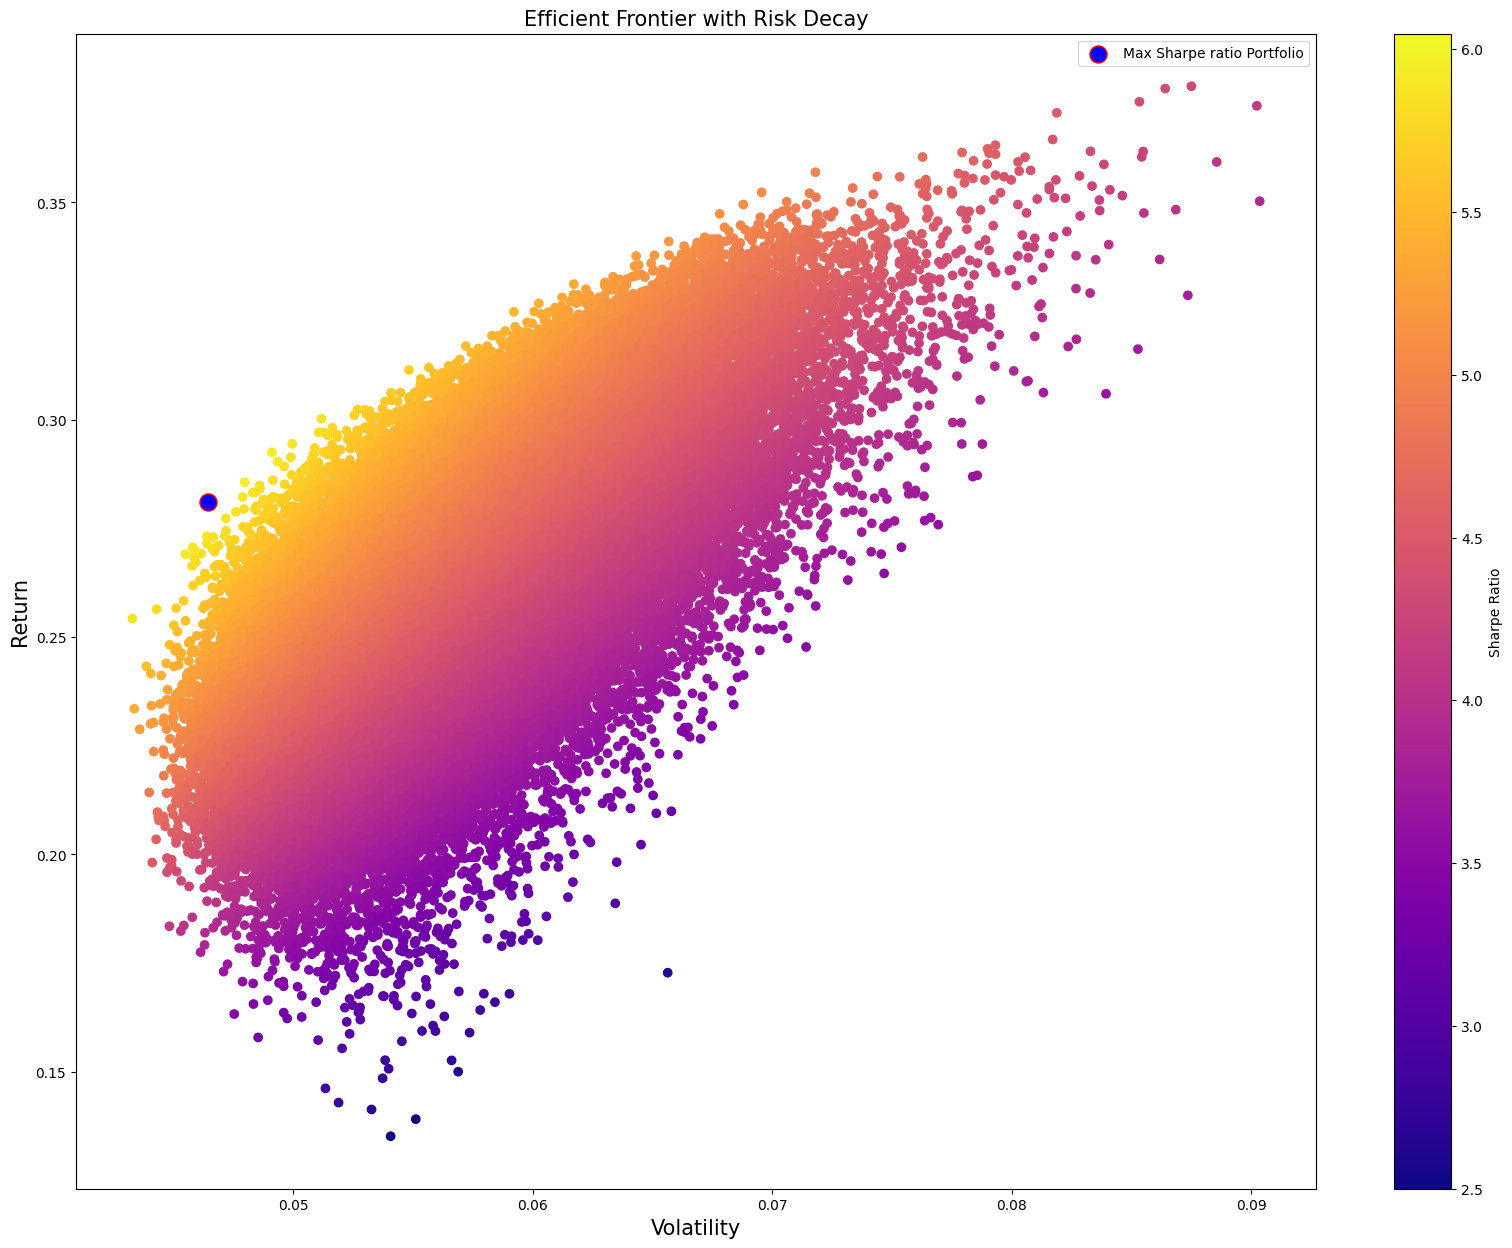

In [28]:
# Plot the efficient frontier
plt.figure(figsize=(20, 15))
plt.scatter(custom_port_volatility, custom_port_return, c=custom_port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier with Risk Decay', fontsize=15)
plt.scatter(custom_max_sr_vol, custom_max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max Sharpe ratio Portfolio')
plt.legend()
plt.show()

In [29]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

# best portfolio return
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

# Display weights for the optimal portfolio
for weight, stock in zip(custom_port_weights[ind], stocks):
    print(f'{round(weight * 100, 2)}% of {stock} should be bought.')

# Display the optimal portfolio return
print(f'\nMarkowitz with risk decay optimal portfolio return is: {round(custom_max_sr_ret * 100, 2)}% with volatility \
{custom_max_sr_vol}')


0.37 % of AMZN should be bought.
17.7 % of TSLA should be bought.
23.13 % of META should be bought.
1.6 % of MSFT should be bought.
36.7 % of NVDA should be bought.
4.14 % of AVGO should be bought.
16.35 % of FICO should be bought.

Markowitz optimal portfolio return is : 30.15% with volatility 0.32251137723043655
4.93% of AMZN should be bought.
5.04% of TSLA should be bought.
23.31% of META should be bought.
12.82% of MSFT should be bought.
18.08% of NVDA should be bought.
13.71% of AVGO should be bought.
22.11% of FICO should be bought.

Markowitz with risk decay optimal portfolio return is: 28.1% with volatility 0.046468495987597974


Test for Allocations

In [30]:
# Define your data for each model
returns_model1 = np.array([0.21, 8.74, 27.25, 0.33, 35.48, 3.42, 24.56])
returns_model2 = np.array([8.62, 15.89, 9.26, 16.0, 11.6, 18.13, 20.51])

# Shapiro-Wilk test for normality
stat_model1, p_value_model1 = shapiro(returns_model1)
stat_model2, p_value_model2 = shapiro(returns_model2)

# Output the results
print("Shapiro-Wilk Test Results:")
print(f"Model 1 - p-value: {p_value_model1}, Statistic: {stat_model1}")
print(f"Model 2 - p-value: {p_value_model2}, Statistic: {stat_model2}")

# Interpret the results
alpha = 0.05
if p_value_model1 > alpha:
    print("Model 1 data appears to be normally distributed.")
else:
    print("Model 1 data does not appear to be normally distributed.")

if p_value_model2 > alpha:
    print("Model 2 data appears to be normally distributed.")
else:
    print("Model 2 data does not appear to be normally distributed.")


Shapiro-Wilk Test Results:
Model 1 - p-value: 0.1759101301431656, Statistic: 0.8673393726348877
Model 2 - p-value: 0.5449262857437134, Statistic: 0.9292958378791809
Model 1 data appears to be normally distributed.
Model 2 data appears to be normally distributed.


In [31]:
# Portfolio allocations under the traditional MVO model
allocations_model_mvo = [0.21, 8.74, 27.25, 0.33, 35.48, 3.42, 24.56]

# Portfolio allocations under the modified MVO model with risk decay
allocations_model_mvo_decay = [8.62, 15.89, 9.26, 16.0, 11.6, 18.13, 20.51]

# Paired t-test
statistic, p_value = ttest_rel(allocations_model_mvo, allocations_model_mvo_decay)

# Print the results
print("Paired T-Test Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis. CONCLUSION: There is no significant difference in the performance of portfolio allocations between the two models.")
else:
    print("Reject the null hypothesis. CONCLUSION: There is a significant difference in the performance of portfolio allocations between the two models.")


Paired T-Test Statistic: -0.00047903759226994254
P-value: 0.9996333132449016
Fail to reject the null hypothesis. CONCLUSION: There is no significant difference in the performance of portfolio allocations between the two models.


Test for volatility

In [32]:
from scipy.stats import mannwhitneyu

# Volatility scores for each model
volatility_model_mvo = 0.341253701049455
volatility_model_mvo_decay = 0.046467679253921604

# Overall return percentages for each model
return_model_mvo = 32.14
return_model_mvo_decay = 28.19

# Mann-Whitney U test for volatility
statistic_volatility, p_value_volatility = mannwhitneyu([volatility_model_mvo], [volatility_model_mvo_decay])

# Mann-Whitney U test for return
statistic_return, p_value_return = mannwhitneyu([return_model_mvo], [return_model_mvo_decay])

# Print the results
print("Mann-Whitney U Test for Volatility - Statistic:", statistic_volatility)
print("P-value for Volatility:", p_value_volatility)

print("\nMann-Whitney U Test for Return - Statistic:", statistic_return)
print("P-value for Return:", p_value_return)

# Interpret the results
alpha = 0.05
if p_value_volatility > alpha:
    print("\nFail to reject the null hypothesis. There is no significant difference in volatility between the two models.")
else:
    print("\nReject the null hypothesis. There is a significant difference in volatility between the two models.")

if p_value_return > alpha:
    print("\nFail to reject the null hypothesis. There is no significant difference in return between the two models.")
else:
    print("\nReject the null hypothesis. There is a significant difference in return between the two models.")


Mann-Whitney U Test for Volatility - Statistic: 1.0
P-value for Volatility: 1.0

Mann-Whitney U Test for Return - Statistic: 1.0
P-value for Return: 1.0

Fail to reject the null hypothesis. There is no significant difference in volatility between the two models.

Fail to reject the null hypothesis. There is no significant difference in return between the two models.


The percentage change is: 29.48%


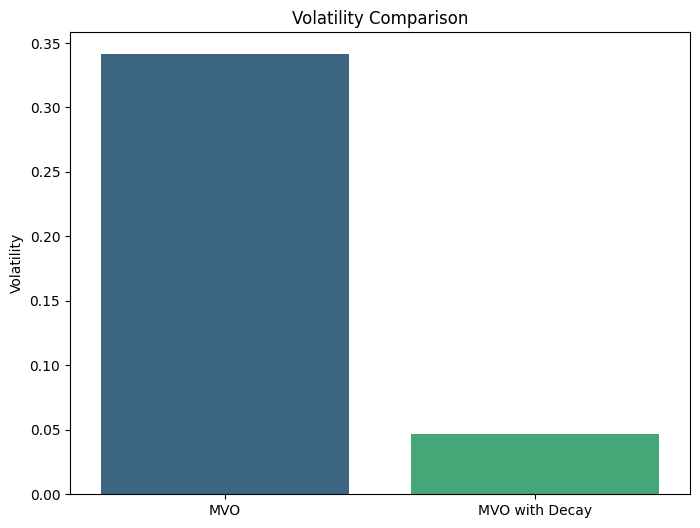

In [33]:
# Data for volatility comparison
volatility_model_mvo = 0.341253701049455
volatility_model_mvo_decay = 0.046467679253921604

# percentage_difference
percentage_difference = (volatility_model_mvo - volatility_model_mvo_decay) * 100

print(f"The percentage change is: {percentage_difference:.2f}%")

# Create a visually appealing bar chart for volatility comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=['MVO', 'MVO with Decay'], y=[volatility_model_mvo, volatility_model_mvo_decay], palette='viridis')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()

The percentage change is: 3.95%


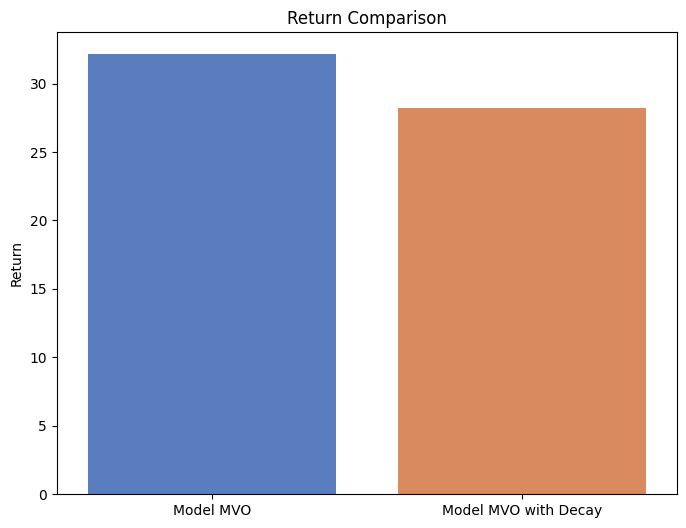

In [34]:
# Data for return comparison
return_model_mvo = 32.14
return_model_mvo_decay = 28.19

# percentage_difference
percentage_diff = (return_model_mvo - return_model_mvo_decay)

print(f"The percentage change is: {percentage_diff:.2f}%")

# Create a visually appealing bar chart for return comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=['Model MVO', 'Model MVO with Decay'], y=[return_model_mvo, return_model_mvo_decay], palette='muted')
plt.ylabel('Return')
plt.title('Return Comparison')
plt.show()